In [22]:
!pip install gym
!pip install stable_baselines3
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [7]:
!pip install imageio
!pip install procgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 9.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.7/267.7 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 51.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 24.4 MB/s eta 0:00:00


In [23]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecMonitor, VecFrameStack, DummyVecEnv

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
import torch


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import imageio


import sys
sys.path.append('../') #This is added so we can import from the source folder
from src.policies_impala import ImpalaCNN
from src.visualisation_functions import *


env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 



In [24]:
@torch.no_grad()
def generate_action(model, observation):
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

    model_output = model(observation)
    
    logits = model_output[0].logits  # discard the output of the critic in our actor critic network
    
    probabilities = torch.softmax(logits, dim=-1)
    
    action = torch.multinomial(probabilities, 1).item() 
    return action

def load_model(model_path = 'model_1400_latest.pt'):
    observation_space = env.observation_space
    action_space = env.action_space.n
    model = ImpalaCNN(observation_space, action_space)
    model.load_from_file(model_path, device="cpu")
    return model


def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False):

    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames=[]
    
    

    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        action = generate_action(model, observation)  
        observation, reward, done, info = env.step(action)
        # observation = colour_swap(observation)
        total_reward += reward
        observations.append(observation)
        count +=1
        if count >= 200:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames, observations

In [25]:
model = load_model()

save_gif_option = True  
for episode in range(1):
    # env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
    total_reward, frames, observations = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")



/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/opt/conda/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (e

Episode 1 finished with total reward: 10.0


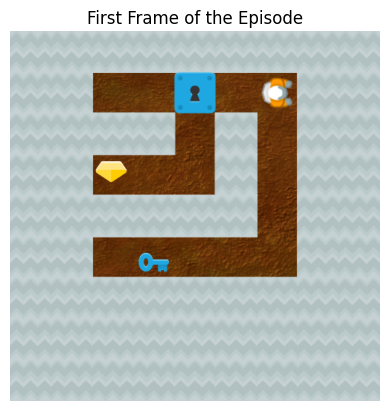

In [26]:
if frames:
    plt.imshow(frames[0])
    plt.title("First Frame of the Episode")
    plt.axis('off')  
    plt.show()
else:
    print("No frames captured.")

In [17]:
import imageio

def create_gif(frames, filename, duration=0.1):
    # Write frames to GIF file
    imageio.mimsave(filename, frames, duration=duration)


create_gif(frames, "episode_gif.gif")


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def swap_colours(observation):
    blue_key_colors = [
        [27, 177, 232],
        [20, 150, 198],
        [22, 161, 212]
    ]
    green_key_colors = [
        [125, 212, 70],
        [98, 189, 34],
        [110, 195, 56]
    ]

    # Create a copy of the observation array to modify
    modified_observation = observation.copy()

    # Swap the colors of blue and green keys
    for blue_color, green_color in zip(blue_key_colors, green_key_colors):
        # Find pixels that match the blue color within a tolerance
        blue_mask = np.abs(observation - blue_color).sum(axis=-1) < 65
        modified_observation[blue_mask] = green_color

        # Find pixels that match the green color within a tolerance
        green_mask = np.abs(observation - green_color).sum(axis=-1) < 65
        modified_observation[green_mask] = blue_color
        

    return observation

    

def plot_heist_observation(observation):
    # Define the colors to swap

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot the modified observation
    ax.imshow(observation)

    # Remove the axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the plot
    plt.show()

In [20]:
[27, 177, 232] in observations[0]

False

In [4]:
!pip install opencv-python-headless


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 16.2 MB/s eta 0:00:0000:0100:01


In [66]:
#reading some images : blue key and gem only in opencv

def convert_png_obs(image_png_name):
    image = cv2.imread(image_png_name)

    # Resize the image to match the original observation dimensions
    image = cv2.resize(image, (64, 64))

    # Convert the color format if necessary
    if image.shape[2] == 4:  # RGBA format
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    elif image.shape[2] == 1:  # Grayscale format
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # Ensure the image data type matches the original observation
    image = image.astype(np.uint8)
    return image

# Use the resized_image as input to your model
# model.predict(resized_image)

In [67]:
only_gem_input = convert_png_obs('only_gem.png')
only_blue_key_input = convert_png_obs('blue_key_no_door.png')
#print(only_gem_input)
#print(only_blue_key_input)
print(only_blue_key_input- only_gem_input)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [70]:
def print_non_zero_entries_numpy(array):
    # Find indices of non-zero elements
    non_zero_indices = np.nonzero(array)
    # Iterate through non-zero elements and print them
    for idx in zip(*non_zero_indices):
        print(f"Index: {idx}, Value: {array[idx]}")

print_non_zero_entries_numpy(only_blue_key_input- only_gem_input)

Index: (10, 29, 0), Value: 1
Index: (10, 29, 1), Value: 1
Index: (10, 29, 2), Value: 1
Index: (10, 30, 0), Value: 15
Index: (10, 30, 1), Value: 14
Index: (10, 30, 2), Value: 14
Index: (10, 31, 0), Value: 252
Index: (10, 31, 1), Value: 251
Index: (10, 31, 2), Value: 249
Index: (10, 32, 0), Value: 6
Index: (10, 32, 1), Value: 7
Index: (10, 32, 2), Value: 10
Index: (10, 33, 0), Value: 3
Index: (10, 33, 1), Value: 2
Index: (10, 33, 2), Value: 4
Index: (10, 34, 0), Value: 247
Index: (10, 34, 1), Value: 247
Index: (10, 34, 2), Value: 243
Index: (11, 29, 0), Value: 192
Index: (11, 29, 1), Value: 35
Index: (11, 29, 2), Value: 121
Index: (11, 30, 0), Value: 109
Index: (11, 30, 1), Value: 253
Index: (11, 30, 2), Value: 105
Index: (11, 31, 0), Value: 97
Index: (11, 31, 1), Value: 241
Index: (11, 31, 2), Value: 88
Index: (11, 32, 0), Value: 251
Index: (11, 32, 1), Value: 251
Index: (11, 32, 2), Value: 249
Index: (11, 33, 0), Value: 1
Index: (11, 33, 1), Value: 1
Index: (11, 33, 2), Value: 1
Index:

In [109]:
def run_with_cache(input):
    activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Initialize a placeholder for processed output
        processed_output = []
        
        for item in output:
            # Check if the item is a tensor and detach it
            if isinstance(item, torch.Tensor):
                processed_output.append(item.detach())
            # If the item is a Categorical, you might want to extract its logits or probs
            elif isinstance(item, torch.distributions.Categorical):
                processed_output.append(item.logits.detach())
            else:
                # Handle other types as necessary
                processed_output.append(item)
        
        # Save the processed output in the activations dictionary
        activations[name] = tuple(processed_output)
    return hook

    # Adjust the layer paths as per your model's architecture
    layer_paths = [
        'conv_seqs.0.conv',
        'conv_seqs.0.res_block0.conv0',

    ]

    def register_hook_by_path(model, path, name):
        elements = path.split('.')
        current_model = model
        for i, element in enumerate(elements):
            if '[' in element:
                base, index = element.replace(']', '').split('[')
                index = int(index)
                current_model = getattr(current_model, base)[index]
            else:
                current_model = getattr(current_model, element)

        # Register the hook if at the last element
        current_model.register_forward_hook(get_activation(name))

    # Register hooks
    for path in layer_paths:
        register_hook_by_path(model, path, path.replace('.', '_'))

    # Ensure the input tensor is in the correct format
    observation = torch.tensor(input, dtype=torch.float32).unsqueeze(0)
    output = model(observation)
    

    return output, activations


In [110]:
_, cache_gem_only = run_with_cache(only_gem_input)
_,cache_blue_key_only = run_with_cache(only_blue_key_input)
print(cache_gem_only['conv_seqs_0_conv'][0])

TypeError: cannot unpack non-iterable NoneType object

In [107]:
def print_non_zero_entries_tensor(tensor):
    # Find non-zero elements
    print("inside this function")
    non_zeros = torch.nonzero(tensor, as_tuple=True)
    # Iterate through non-zero elements
    for idx in zip(*non_zeros):
        print(f"Index: {idx}, Value: {tensor[idx]}")


In [108]:
_, cache_gem_only = run_with_cache(only_gem_input)
_,cache_blue_key_only = run_with_cache(only_blue_key_input)
difference = diff_activations(cache_gem_only,cache_blue_key_only)
for key in difference.keys():
        print_non_zero_entries_tensor(diff_activations(cache_gem_only,cache_blue_key_only)[key])

inside this function
inside this function


In [32]:
def plot_layer_activations_dynamic_grid(activations, layer_name, save_filename=None):
    # Check if the specified layer's activations are available
    if layer_name not in activations:
        print(f"No activations found for layer: {layer_name}")
        return
    
    # Extract the activation tensor for the specified layer
    activation_tensor = activations[layer_name][0].cpu().numpy()
    
    # Adjust for tensors that are 3D (missing batch dimension)
    if activation_tensor.ndim == 3:
        activation_tensor = activation_tensor[np.newaxis, :]  # Add a batch dimension
    
    # Determine the number of activation maps (filters) for this layer
    num_activations = activation_tensor.shape[1]
    
    # Calculate grid size
    grid_size = math.ceil(math.sqrt(num_activations))
    
    # Create a figure with dynamic subplots based on the number of activations
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
    
    # Initialize an index for activation maps
    activation_idx = 0
    
    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            
            # Plot the activation map if we haven't gone through all of them yet
            if activation_idx < num_activations:
                ax.imshow(activation_tensor[0, activation_idx, :, :], cmap='viridis', aspect='auto')
                ax.set_title(f'Filter {activation_idx+1}', fontsize=8)
                activation_idx += 1
            else:
                ax.axis('off')  # Hide axes without data
            
            ax.axis('off')  # Hide axes for all plots for a cleaner look
    
    plt.tight_layout()
    
    # Save or show the plot
    if save_filename:
        plt.savefig(save_filename)
        plt.close()
    else:
        plt.show()

In [ ]:
#the patching method
# Assuming you have already defined 'register_hook_by_path'

activations_cache = {}  # Dictionary to store activations

def save_activations(module, input, output, name):
    """Save the activations to the cache."""
    activations_cache[name] = output.detach()

def patch_activations(module, input, output, name):
    """Patch the activations from the cache."""
    if name in activations_cache:
        # Replace the current activations with the cached ones
        return activations_cache[name]

# Run the model with the first input
for name in layer_names:
    hook = model.register_forward_hook(lambda module, input, output: save_activations(module, input, output, name))
# forward pass with the first input to cache activations
output1 = model(first_input)
# remove the hooks to avoid saving activations in the next forward pass
for hook in hooks:
    hook.remove()

# Now run the model with the second input, patching in cached activations
hooks = []
for name in layer_names:
    hook = model.register_forward_pre_hook(lambda module, input: patch_activations(module, input, activations_cache, name))
# forward pass with the second input where cached activations will be patched in
output2 = model(second_input)
# remove the hooks after the forward pass
for hook in hooks:
    hook.remove()


In [40]:
import matplotlib.pyplot as plt

def plot_all_layer_activations(activations, layer_names, max_cols=None, save_filename=None):
    # Determine the maximum number of filters across the specified layers
    max_filters = 0
    for layer_name in layer_names:
        if layer_name in activations:
            tensor_shape = activations[layer_name][0].shape
            num_filters = tensor_shape[0] if len(tensor_shape) == 3 else tensor_shape[1]
            if num_filters > max_filters:
                max_filters = num_filters
    max_filters = min(max_filters, max_cols) if max_cols is not None else max_filters
    
    # Create a figure with subplots
    num_layers = len(layer_names)
    fig, axes = plt.subplots(num_layers, max_filters, figsize=(max_filters * 2, num_layers * 2))
    
    for i, layer_name in enumerate(layer_names):
        if layer_name not in activations:
            print(f"No activations found for layer: {layer_name}")
            continue
        
        activation_tensor = activations[layer_name][0].cpu().numpy()
        # Adjust for tensors that are 3D (missing batch dimension)
        if activation_tensor.ndim == 3:
            activation_tensor = activation_tensor[np.newaxis, :]  # Add a batch dimension
        
        num_filters = activation_tensor.shape[1]
        
        for j in range(max_filters):
            ax = axes[i, j] if num_layers > 1 else axes[j]
            if j < num_filters:
                # Plot the activation map for filter j
                ax.imshow(activation_tensor[0, j, :, :], cmap='viridis', aspect='auto')
                ax.set_title(f'{layer_name}\nFilter {j+1}', fontsize=8)
                ax.axis('off')
            else:
                # Hide axes without data
                ax.axis('off')
    
    plt.tight_layout()

    if save_filename:
        plt.savefig(save_filename)
        plt.close() 
    else:
        plt.show()
        plt.show()

layer_names = [
    # 'conv_seqs_0_conv',
    # 'conv_seqs_0_res_block0_conv0',
    # 'conv_seqs_0_res_block0_conv1',
    # 'conv_seqs_0_res_block1_conv0',
    # 'conv_seqs_0_res_block1_conv1',
    'conv_seqs_1_conv',
    # 'conv_seqs_1_res_block0_conv0',
    # 'conv_seqs_1_res_block0_conv1',
    # 'conv_seqs_1_res_block1_conv0',
    # 'conv_seqs_1_res_block1_conv1',
    # 'conv_seqs_2_conv',
    # 'conv_seqs_2_res_block0_conv0',
    # 'conv_seqs_2_res_block0_conv1',
    # 'conv_seqs_2_res_block1_conv0',
    'conv_seqs_2_res_block1_conv1',
    # 'max_pool2d'
]


for i, observation in enumerate([only_gem_input]):
    # Run your data through the model
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)
    activations = {}
    output = model(observation)
    for layer_name in layer_names:
        plot_layer_activations_dynamic_grid(activations, layer_name, save_filename=f"episode_{i}_{layer_name}_plot_later.png")

    # plot_all_layer_activations(activations, layer_names, max_cols=20, save_filename=f"../activation_plot_frames/episode_{i}_plot.png")


FileNotFoundError: [Errno 2] No such file or directory: '../activation_plot_frames/episode_0_conv_seqs_1_conv_plot_later.png'

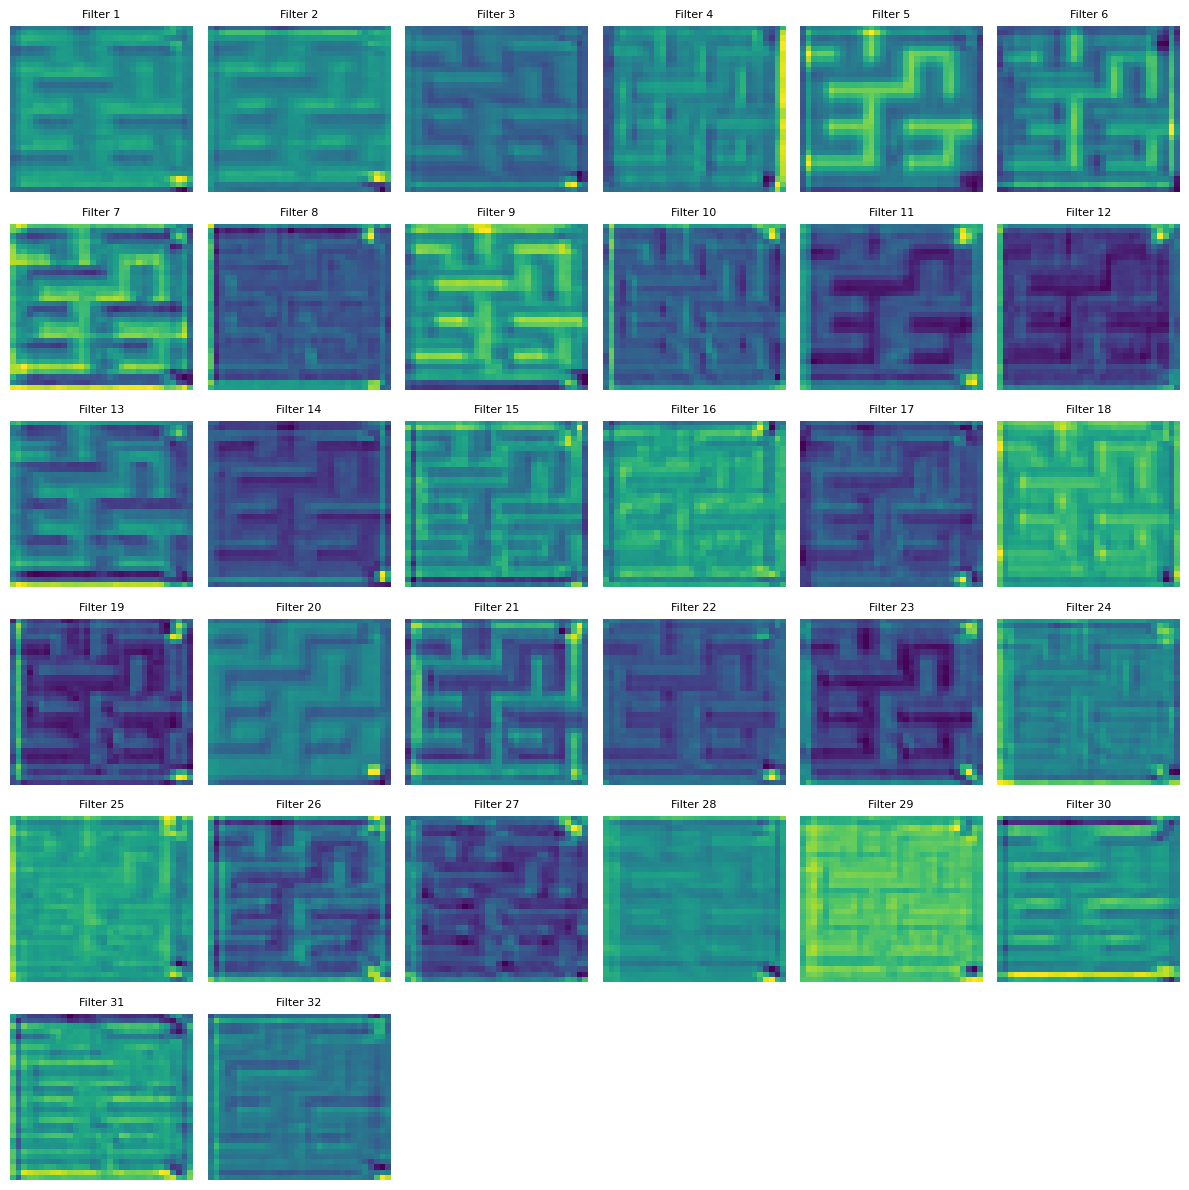

In [38]:
activations = {}
output = model(observation)
for layer_name in layer_names:
    plot_layer_activations_dynamic_grid(activations, layer_name, save_filename=f"../activation_plot_frames/episode_{i}_{layer_name}_plot_later.png")


In [58]:
import glob
import imageio

def create_gif_from_folder(folder_path, gif_filename):
    # Construct the pattern to match the filenames
    pattern = f"{folder_path}/episode_*_plot.png"
    
    # Use glob to find matching filenames
    filenames = sorted(glob.glob(pattern), key=lambda x: int(x.split('_')[-2]))
    
    # Check if filenames list is not empty
    if not filenames:
        print("No files found matching the pattern. Please check the folder path and naming convention.")
        return
        
    # Create the GIF
    with imageio.get_writer(gif_filename, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    
    print(f"GIF created successfully: {gif_filename}")

# Example usage:
folder_path = "../activation_plot_frames"  # Adjust this path as needed
gif_filename = "activation_visualization.gif"  # Name of the output GIF file
create_gif_from_folder(folder_path, gif_filename)


No files found matching the pattern. Please check the folder path and naming convention.


In [ ]:
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, shape: {param.size()}")

Parameter name: conv_seqs.0.conv.weight, shape: torch.Size([16, 3, 3, 3])
Parameter name: conv_seqs.0.conv.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block0.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block0.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv0.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv0.bias, shape: torch.Size([16])
Parameter name: conv_seqs.0.res_block1.conv1.weight, shape: torch.Size([16, 16, 3, 3])
Parameter name: conv_seqs.0.res_block1.conv1.bias, shape: torch.Size([16])
Parameter name: conv_seqs.1.conv.weight, shape: torch.Size([32, 16, 3, 3])
Parameter name: conv_seqs.1.conv.bias, shape: torch.Size([32])
Parameter name: conv_seqs.1.res_block0.conv0.weight, shape: torch.Size([32, 3

In [ ]:
#inputs the 2 images 
#Take away those the activations from one image to the other
#function that is called read modified image
def residual_mean_ablate(seed=IntSlider(min=0, max=20, step=1, value=0), block=Dropdown(options=[1, 2, 3], value=1), res=Dropdown(options=[1, 2], value=1), component=Dropdown(options=residual_components, value='conv1_out')):
    layer_name = f'embedder.block{block}.res{res}.{component}'
    hook.run_with_input(obs)
    random_values = hook.get_value_by_label(layer_name)
    patches = get_mean_patch(values=random_values, layer_name=layer_name) 
    
    venv = create_venv(num=1, start_level=seed, num_levels=1)
    fig, axs, info = compare_patched_vfields(venv, patches, hook, ax_size=5, show_diff = True)
    
    fig.suptitle(f'Mean patching layer {layer_name}')
    plt.show()